# **UAS BIG DATA MINING**

# Analisis dan Prediksi Time Series Harga Ethereum dengan Arsitektur LSTM

Nama : Dyah Pramudya Sari

NIM : 22.11.5097

Link Dataset : https://www.kaggle.com/datasets/kapturovalexander/bitcoin-and-ethereum-prices-from-start-to-2023


In [4]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df1 = pd.read_csv('/content/drive/MyDrive/Semester 5/Big Data Dan Data Mining/ETH-USD (2017-2024).csv.xls')
df2 = pd.read_csv('/content/drive/MyDrive/Semester 5/Big Data Dan Data Mining/ETH-USD (01-05.2024).csv.xls')

In [7]:
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08
1,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08
2,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09
3,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09
4,2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1.069680e+09


In [8]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-01,2282.870361,2352.327881,2267.018066,2352.327881,2352.327881,6.906766e+09
1,2024-01-02,2352.593506,2431.212402,2348.892334,2355.836426,2355.836426,1.291054e+10
2,2024-01-03,2355.981445,2385.117676,2113.925293,2210.761963,2210.761963,1.933293e+10
3,2024-01-04,2210.529053,2294.608154,2204.865723,2269.038086,2269.038086,1.104456e+10
4,2024-01-05,2269.409424,2276.764648,2209.537109,2268.647217,2268.647217,1.086095e+10


# EDA & Preprocessing Data

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2264 non-null   object 
 1   Open       2263 non-null   float64
 2   High       2263 non-null   float64
 3   Low        2263 non-null   float64
 4   Close      2263 non-null   float64
 5   Adj Close  2263 non-null   float64
 6   Volume     2263 non-null   float64
dtypes: float64(6), object(1)
memory usage: 123.9+ KB


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       122 non-null    object 
 1   Open       121 non-null    float64
 2   High       121 non-null    float64
 3   Low        121 non-null    float64
 4   Close      121 non-null    float64
 5   Adj Close  121 non-null    float64
 6   Volume     121 non-null    float64
dtypes: float64(6), object(1)
memory usage: 6.8+ KB


In [11]:
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])

In [12]:
df = pd.concat([df1, df2], axis=0)

In [13]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df = df.set_index('Date')

In [15]:
#Menambah Fitur
df['MA5'] = df['Close'].rolling(window=5).mean()
df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
df['Price_Change'] = df['Close'] - df['Open']

In [16]:
df.isna().sum()

,0
Open,2
High,2
Low,2
Close,2
Adj Close,2
Volume,2
MA5,11
Volume_MA5,11
Price_Change,2


In [17]:
df.dropna(inplace=True)

In [18]:
df.drop(columns=['Adj Close'], inplace=True)

In [19]:
df.drop_duplicates()

,Open,High,Low,Close,Volume,MA5,Volume_MA5,Price_Change
Date,,,,,,,,
2017-11-14,316.763000,340.177002,316.763000,337.631012,1.069680e+09,315.237799,1.090667e+09,20.868012
2017-11-15,337.963989,340.911987,329.812988,333.356995,7.226660e+08,322.058600,1.058003e+09,-4.606994
2017-11-16,333.442993,336.158997,323.605988,330.924011,7.972540e+08,325.307202,1.048994e+09,-2.518982
2017-11-17,330.166992,334.963989,327.523010,332.394012,6.217330e+08,330.204407,8.506446e+08,2.227020
2017-11-18,331.980011,349.615997,327.687012,347.612000,6.496390e+08,336.383606,7.721944e+08,15.631989
...,...,...,...,...,...,...,...,...
2024-04-25,3139.624268,3190.976318,3074.804688,3156.509521,1.398903e+10,3173.033398,1.210039e+10,16.885253
2024-04-26,3156.384033,3166.188721,3103.104004,3130.164795,1.062233e+10,3169.608643,1.234598e+10,-26.219238
2024-04-27,3129.727051,3279.451172,3071.340088,3252.168213,1.182079e+10,3179.711865,1.229737e+10,122.441162


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2375 entries, 2017-11-14 to 2024-04-29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2375 non-null   float64
 1   High          2375 non-null   float64
 2   Low           2375 non-null   float64
 3   Close         2375 non-null   float64
 4   Volume        2375 non-null   float64
 5   MA5           2375 non-null   float64
 6   Volume_MA5    2375 non-null   float64
 7   Price_Change  2375 non-null   float64
dtypes: float64(8)
memory usage: 167.0 KB


In [21]:
fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])
fig.update_layout(title='Ethereum Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [22]:
df.head(10)

,Open,High,Low,Close,Volume,MA5,Volume_MA5,Price_Change
Date,,,,,,,,
2017-11-14,316.763000,340.177002,316.763000,337.631012,1.069680e+09,315.237799,1.090667e+09,20.868012
2017-11-15,337.963989,340.911987,329.812988,333.356995,7.226660e+08,322.058600,1.058003e+09,-4.606994
2017-11-16,333.442993,336.158997,323.605988,330.924011,7.972540e+08,325.307202,1.048994e+09,-2.518982
2017-11-17,330.166992,334.963989,327.523010,332.394012,6.217330e+08,330.204407,8.506446e+08,2.227020
2017-11-18,331.980011,349.615997,327.687012,347.612000,6.496390e+08,336.383606,7.721944e+08,15.631989
2017-11-19,347.401001,371.290985,344.739990,354.385986,1.181530e+09,339.734601,7.945644e+08,6.984985
2017-11-20,354.093994,372.136993,353.289001,366.730011,8.070270e+08,346.409204,8.114366e+08,12.636017
2017-11-21,367.442993,372.470001,350.692993,360.401001,9.499120e+08,352.304602,8.419682e+08,-7.041992
2017-11-22,360.312012,381.420013,360.147003,380.652008,8.008190e+08,361.956201,8.777854e+08,20.339996


# Normalisasi Data

In [23]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [24]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

In [25]:
print(df_scaled.head())

                Open      High       Low     Close    Volume       MA5  \
Date                                                                     
2017-11-14  0.049195  0.053020  0.050469  0.053582  0.005342  0.049463   
2017-11-15  0.053681  0.053173  0.053284  0.052678  0.001204  0.050936   
2017-11-16  0.052724  0.052184  0.051945  0.052163  0.002093  0.051638   
2017-11-17  0.052031  0.051936  0.052790  0.052474  0.000000  0.052695   
2017-11-18  0.052415  0.054984  0.052825  0.055693  0.000333  0.054030   

            Volume_MA5  Price_Change  
Date                                  
2017-11-14    0.005145      0.643303  
2017-11-15    0.004617      0.625921  
2017-11-16    0.004472      0.627346  
2017-11-17    0.001267      0.630584  
2017-11-18    0.000000      0.639730  


In [26]:
df_scaled = df_scaled.to_numpy()

In [27]:
sequence_length = 14
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i])
    y.append(df_scaled[i, 3])  # Predicting 'Close' price
X, y = np.array(X), np.array(y)

# Split Data

In [28]:
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [29]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1652, 14, 8)
y_train.shape =  (1652,)
X_test.shape =  (709, 14, 8)
y_test.shape =  (709,)


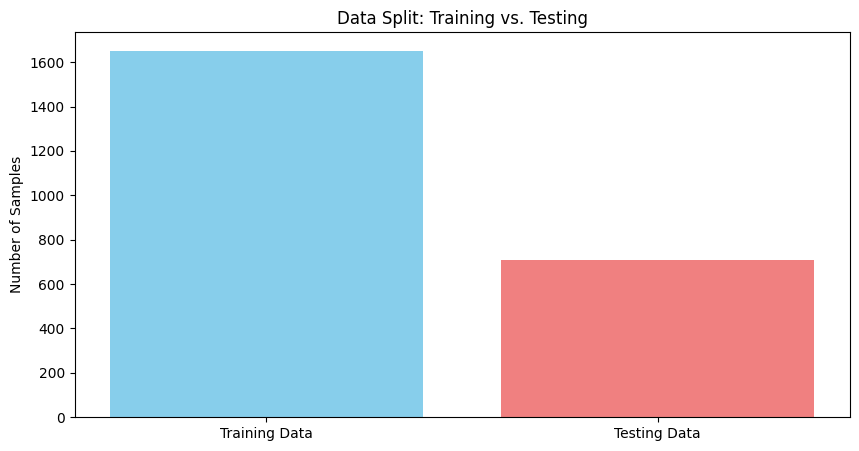

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(['Training Data', 'Testing Data'], [len(X_train), len(X_test)], color=['skyblue', 'lightcoral'])
plt.title('Data Split: Training vs. Testing')
plt.ylabel('Number of Samples')
plt.show()

# Model LSTM

In [31]:
model = Sequential([
        LSTM(60,activation='tanh' ,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.15),
        LSTM(50,activation='tanh' ,return_sequences=True),
        Dropout(0.15),
        LSTM(40,activation='tanh' ,return_sequences=False),
        Dropout(0.15),
        Dense(1)
    ])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 60)              │          16,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 14, 50)              │          22,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,361 (208.44 KB)

 Trainable params: 53,361 (208.44 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0142 - val_loss: 0.0013
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 8.4622e-04
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0027 - val_loss: 8.0078e-04
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 7.3743e-04
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━

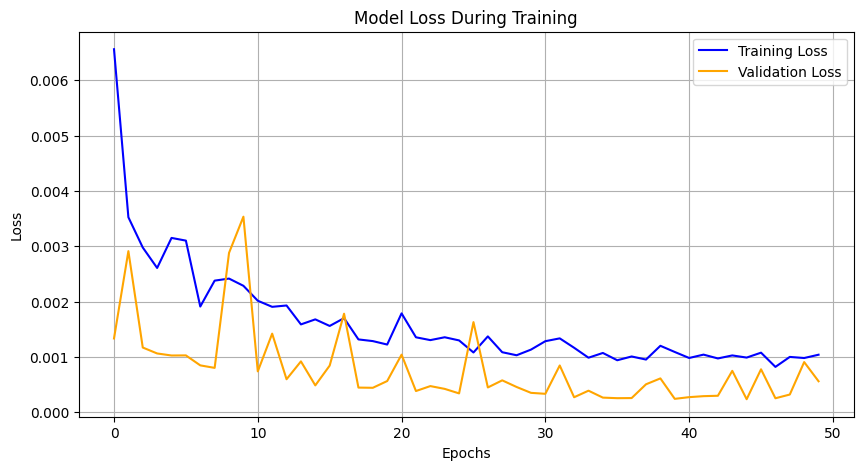

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Hasil Model

In [34]:
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 7)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 7)), y_pred), axis=1))[:, -1]

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


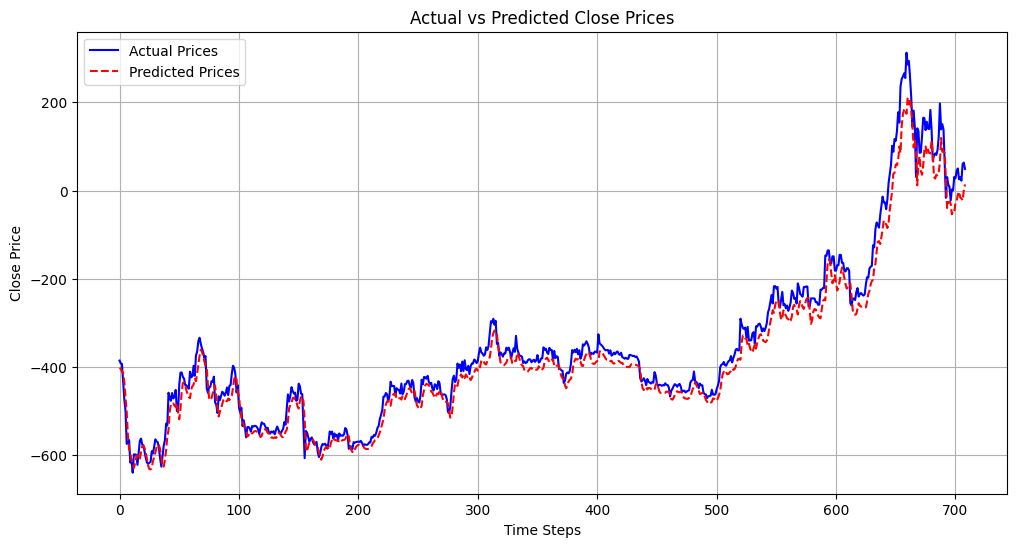

In [35]:
# Visualizing predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

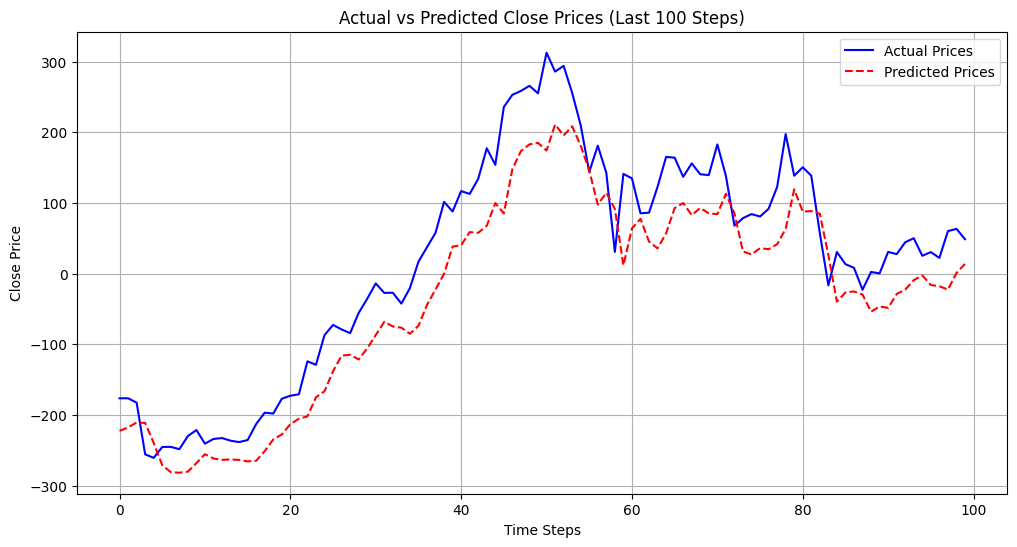

In [36]:
# Melihat 100 data terakhir dari prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[-100:], label='Actual Prices', color='blue')
plt.plot(y_pred_rescaled[-100:], label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Close Prices (Last 100 Steps)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Evaluasi Model

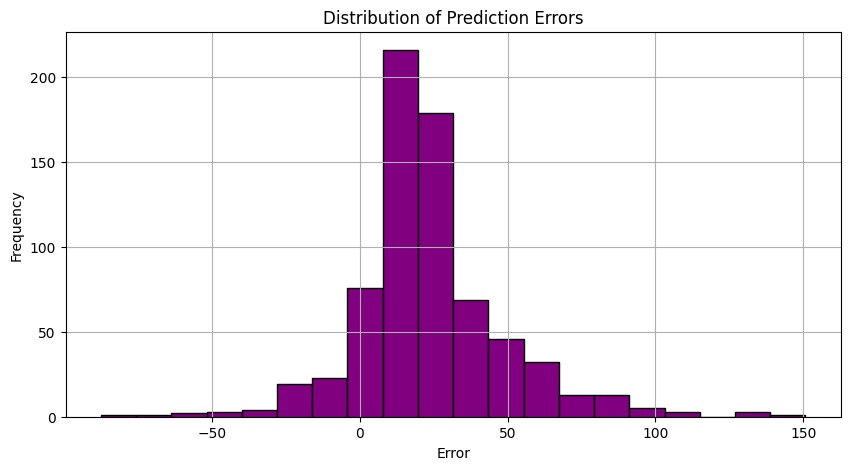

In [37]:
errors = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [38]:
# Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Mean Squared Error (MSE): 1200.8532
Root Mean Squared Error (RMSE): 34.6533
Mean Absolute Error (MAE): 27.1977
R-squared (R2) Score: 0.9672
